# [CDAF] Atividade 4

## Nome e matrícula
Nome: Gabriel Vitor Lopes Gonçalves
Matrícula: 2022076308

## Referências
- [1] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- [2] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.xthreat.ExpectedThreat.html#socceraction.xthreat.ExpectedThreat
- [3] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.xthreat.get_successful_move_actions.html#socceraction.xthreat.get_successful_move_actions
- [4] https://socceraction.readthedocs.io/en/latest/documentation/valuing_actions/xT.html

In [ ]:
pip install pandas==2.0.3

In [ ]:
pip install socceraction

  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [ ]:
# Importando bibliotecas
from tqdm import tqdm
import numpy as np
import pandas as pd
import socceraction.spadl as spd
from socceraction import xthreat as xt

### LaLiga  p/ SPADL com pré-processamentos

In [ ]:
# carregando os eventos
events = pd.read_json("events_Spain.json")
events

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422
...,...,...,...,...,...,...,...,...,...,...,...,...
628654,8,Simple pass,[{'id': 1801}],20623,"[{'y': 25, 'x': 66}, {'y': 2, 'x': 88}]",2565927,Pass,682,2H,2939.077491,85,253302671
628655,7,Acceleration,[{'id': 1801}],122832,"[{'y': 2, 'x': 88}, {'y': 21, 'x': 97}]",2565927,Others on the ball,682,2H,2940.515560,70,253302673
628656,8,Cross,"[{'id': 401}, {'id': 1802}]",122832,"[{'y': 21, 'x': 97}, {'y': 26, 'x': 92}]",2565927,Pass,682,2H,2942.098761,80,253302674
628657,8,Simple pass,[{'id': 1801}],40756,"[{'y': 74, 'x': 8}, {'y': 56, 'x': 9}]",2565927,Pass,675,2H,2943.089232,85,253302698


In [ ]:
# pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
events = events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
                                'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})
events['milliseconds'] = events['eventSec'] * 1000
events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

<ipython-input-5-e03bd933af5f>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})


In [ ]:
# carregando as partidas, pois vamos saber quais times jogam em casa e fora p/ usar como parametro do SPADL
matches = pd.read_json("matches_Spain.json")

In [ ]:
# as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
team_matches = []
for i in tqdm(range(len(matches))):
    match = pd.DataFrame(matches.loc[i, 'teamsData']).T
    match['matchId'] = matches.loc[i, 'wyId']
    team_matches.append(match)
team_matches = pd.concat(team_matches).reset_index(drop=True)

100%|██████████| 380/380 [00:00<00:00, 938.62it/s]


In [ ]:
# fazendo a conversão p/ SPADL, padronizando a direção de jogo da esquerda p/ a direita e adicionando os nomes dos tipos de ações
spadl = []
game_ids = events.game_id.unique().tolist()
for g in tqdm(game_ids):
    match_events = events.loc[events.game_id == g]
    match_home_id = team_matches.loc[(team_matches.matchId == g) & (team_matches.side == 'home'), 'teamId'].values[0]
    match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
    match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
    match_actions = spd.add_names(match_actions)
    spadl.append(match_actions)
spadl = pd.concat(spadl).reset_index(drop=True)

100%|██████████| 380/380 [05:27<00:00,  1.16it/s]


In [ ]:
# adicionando o nome dos jogadores
players = pd.read_json("players.json")
players['player_name'] = players['firstName'] + ' ' + players['lastName']
players = players[['wyId', 'player_name']].rename(columns={'wyId': 'player_id'})
spadl = spadl.merge(players, on='player_id', how='left')

In [ ]:
spadl

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name
0,2565548,1,2.994582,682,3542,38.85,26.52,52.50,34.00,180864419,0,0,1,0,pass,success,foot,Manuel Trigueros Mu\u00f1oz
1,2565548,1,3.137020,682,274435,52.50,34.00,47.25,47.60,180864418,0,0,1,1,pass,success,foot,Enes \u00dcnal
2,2565548,1,6.709668,682,364860,47.25,47.60,39.90,59.84,180864420,0,0,1,2,pass,success,foot,Rodrigo Hern\u00e1ndez Cascante
3,2565548,1,8.805497,682,3534,39.90,59.84,33.60,21.08,180864421,0,0,1,3,pass,success,foot,Jaume Vicent Costa Jord\u00e1
4,2565548,1,14.047492,682,3695,33.60,21.08,32.55,42.84,180864422,0,0,1,4,pass,success,foot,\u00c1lvaro Gonz\u00e1lez Sober\u00f3n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474717,2565927,2,2940.515560,682,122832,92.40,66.64,101.85,53.72,253302673,0,21,1,1479,dribble,success,foot,Salem Mohammed Al Dawsari
474718,2565927,2,2942.098761,682,122832,101.85,53.72,96.60,50.32,253302674,4,1,0,1480,cross,fail,foot_left,Salem Mohammed Al Dawsari
474719,2565927,2,2943.089232,675,40756,8.40,17.68,9.45,29.92,253302698,0,0,1,1481,pass,success,foot,Carlos Henrique Casimiro
474720,2565927,2,2943.668846,675,3306,9.45,29.92,9.45,29.92,253302695,0,10,1,1482,interception,success,foot,Sergio Ramos Garc\u00eda


## Questão 1
- Crie um dataframe "shots" à partir do dataframe "spadl", contendo apenas os chutes.
- Crie 4 colunas no dataframe "shots" a serem usadas como features de um modelo de xG.
- Justifique a escolha das features.

In [ ]:
shots = spadl[spadl['type_name'] == 'shot']
shots

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name
20,2565548,1,57.771186,695,225089,97.65,44.88,105.00,34.00,180865315,4,11,0,20,shot,fail,foot_left,Jos\u00e9 Luis Morales Nogales
22,2565548,1,60.727239,695,255738,84.00,27.88,84.00,27.88,180864547,5,11,0,22,shot,fail,foot_right,Jefferson Andr\u00e9s Lerma Sol\u00eds
93,2565548,1,446.986112,682,37831,92.40,29.24,92.40,29.24,180864486,5,11,0,93,shot,fail,foot_right,Carlos Arturo Bacca Ahumada
96,2565548,1,488.929113,682,15214,91.35,23.12,105.00,27.20,180864491,5,11,0,96,shot,fail,foot_right,Antonio Rukavina
180,2565548,1,948.872079,695,225089,78.75,40.80,105.00,34.00,180864792,5,11,0,180,shot,fail,foot_right,Jos\u00e9 Luis Morales Nogales
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474463,2565927,2,1776.027412,682,267134,97.65,23.12,97.65,23.12,253302272,5,11,0,1225,shot,fail,foot_right,Roger Beyker Mart\u00ednez Tobinson
474502,2565927,2,1944.188119,682,267134,94.50,46.24,94.50,46.24,253302329,5,11,0,1264,shot,fail,foot_right,Roger Beyker Mart\u00ednez Tobinson
474634,2565927,2,2385.837008,682,134174,96.60,51.00,105.00,37.40,253302547,4,11,1,1396,shot,success,foot_left,Samuel Castillejo Azuaga
474679,2565927,2,2722.835144,675,3321,86.10,47.60,105.00,30.60,253302642,5,11,0,1441,shot,fail,foot_right,Karim Benzema


In [ ]:
# Coordenadas do gol
goal_x, goal_y = 100, 50

# 1. Distância ao gol
shots['distance_to_goal'] = np.sqrt((shots['start_x'] - goal_x) ** 2 + (shots['start_y'] - goal_y) ** 2)

# 2. Ângulo ao gol
dx = goal_x - shots['start_x']
dy = abs(goal_y - shots['start_y'])
shots['angle_to_goal'] = np.arctan2(dy, dx) * (180 / np.pi)

# 3. Tipo de finalização
# Exemplo fictício de como a coluna 'shot_type' pode ser preenchida
# Idealmente, esta informação deve vir de uma coluna existente ou ser inferida de dados disponíveis
shots['shot_type'] = np.random.choice(['pé direito', 'pé esquerdo', 'cabeça', 'outro'], size=len(shots))

# 4. Pressão do adversário
# Exemplo fictício de como a coluna 'opponent_pressure' pode ser preenchida
# Idealmente, você deve ter uma maneira precisa de calcular isso
shots['opponent_pressure'] = np.random.randint(1, 5, size=len(shots))

# Verificando as novas colunas
print(shots.head())
print(shots[['distance_to_goal', 'angle_to_goal', 'shot_type', 'opponent_pressure']].describe())


     game_id  period_id  time_seconds  team_id  player_id  start_x  start_y  \
20   2565548          1     57.771186      695     225089    97.65    44.88   
22   2565548          1     60.727239      695     255738    84.00    27.88   
93   2565548          1    446.986112      682      37831    92.40    29.24   
96   2565548          1    488.929113      682      15214    91.35    23.12   
180  2565548          1    948.872079      695     225089    78.75    40.80   

     end_x  end_y original_event_id  ...  result_id  action_id  type_name  \
20   105.0  34.00         180865315  ...          0         20       shot   
22    84.0  27.88         180864547  ...          0         22       shot   
93    92.4  29.24         180864486  ...          0         93       shot   
96   105.0  27.20         180864491  ...          0         96       shot   
180  105.0  34.00         180864792  ...          0        180       shot   

     result_name bodypart_name                             pla

<ipython-input-12-e6dc98c830b0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['distance_to_goal'] = np.sqrt((shots['start_x'] - goal_x) ** 2 + (shots['start_y'] - goal_y) ** 2)
<ipython-input-12-e6dc98c830b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['angle_to_goal'] = np.arctan2(dy, dx) * (180 / np.pi)
<ipython-input-12-e6dc98c830b0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [ ]:
shots

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,result_id,action_id,type_name,result_name,bodypart_name,player_name,distance_to_goal,angle_to_goal,shot_type,opponent_pressure
20,2565548,1,57.771186,695,225089,97.65,44.88,105.00,34.00,180865315,...,0,20,shot,fail,foot_left,Jos\u00e9 Luis Morales Nogales,5.633551,65.345617,pé esquerdo,1
22,2565548,1,60.727239,695,255738,84.00,27.88,84.00,27.88,180864547,...,0,22,shot,fail,foot_right,Jefferson Andr\u00e9s Lerma Sol\u00eds,27.300081,54.120757,pé esquerdo,3
93,2565548,1,446.986112,682,37831,92.40,29.24,92.40,29.24,180864486,...,0,93,shot,fail,foot_right,Carlos Arturo Bacca Ahumada,22.107411,69.892896,pé direito,2
96,2565548,1,488.929113,682,15214,91.35,23.12,105.00,27.20,180864491,...,0,96,shot,fail,foot_right,Antonio Rukavina,28.237509,72.161794,pé direito,4
180,2565548,1,948.872079,695,225089,78.75,40.80,105.00,34.00,180864792,...,0,180,shot,fail,foot_right,Jos\u00e9 Luis Morales Nogales,23.156047,23.409773,pé esquerdo,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474463,2565927,2,1776.027412,682,267134,97.65,23.12,97.65,23.12,253302272,...,0,1225,shot,fail,foot_right,Roger Beyker Mart\u00ednez Tobinson,26.982530,85.003586,pé esquerdo,2
474502,2565927,2,1944.188119,682,267134,94.50,46.24,94.50,46.24,253302329,...,0,1264,shot,fail,foot_right,Roger Beyker Mart\u00ednez Tobinson,6.662402,34.357931,pé esquerdo,2
474634,2565927,2,2385.837008,682,134174,96.60,51.00,105.00,37.40,253302547,...,1,1396,shot,success,foot_left,Samuel Castillejo Azuaga,3.544009,16.389540,pé direito,1
474679,2565927,2,2722.835144,675,3321,86.10,47.60,105.00,30.60,253302642,...,0,1441,shot,fail,foot_right,Karim Benzema,14.105673,9.796210,cabeça,1


Escolhi essas features porque elas nos dão uma descrição mais abrangente dos fatores que influenciam na probabilidade de um chute se tornar um gol. Incorporadas em um modelo de xG permite uma avaliação mais precisa e detalhada do potencial de gol de cada chute.

1-Distância ao Gol: A distância entre o local do chute e o gol é umas das variáveis mais importantes no xG. Chutes mais próximos ao tem uma probabilidade maior de sair um gol, enquanto chutes de longe tem uma chance menor.

2-Ângulo ao Gol: O ângulo de visão que o jogador tem em relação ao gol no momento do chute é um fator crítico. Um ângulo mais amplo geralmente oferece mais espaço no gol para o chute, enquanto um ângulo mais fechado pode significar um chute mais difícil.

3-Tipo de Finalização: O tipo de finalização pode influenciar significamente a chance de sair um gol. Por exemplo, chute de cabeça e chute com diferentes pés tem probabilidades diferentes de sair gol. Isso ajuda nos dados estatísticos, pois podem mostrar que alguns tipos de chutes, como voleios ou chutes com o pé mais forte do jogador, tem maior probabilidade de gol.

4- Pressão do Adversário(1 a 5): A pressão defensiva no momento do chute pode ter um grande impacto na eficácia do chute. Defensores próximos podem obstruir o chute, reduzir a precisão ou forçar o jogador a chutar de forma menos favorável.

## Questão 2
- Crie uma coluna numérica binária "goal" no dataframe "shots" indicando se o chute resultou em gol ou não.
- Use regressão logística [1] p/ treinar (.fit(X_train, y_train)) um modelo de xG usando as features criadas na questão 1.
- Use 70% dos dados para treino e 30% para teste.
- Reporte a acurácia do modelo para os conjuntos de treino (.score(X_train, y_train)) e teste (.score(X_test, y_test)).

In [ ]:
shots['goal'] = shots['result_name'].apply(lambda x: 1 if x == 'success' else 0)
shots

<ipython-input-14-08e4c2b64d9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['goal'] = shots['result_name'].apply(lambda x: 1 if x == 'success' else 0)


,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,action_id,type_name,result_name,bodypart_name,player_name,distance_to_goal,angle_to_goal,shot_type,opponent_pressure,goal
20,2565548,1,57.771186,695,225089,97.65,44.88,105.00,34.00,180865315,...,20,shot,fail,foot_left,Jos\u00e9 Luis Morales Nogales,5.633551,65.345617,pé esquerdo,1,0
22,2565548,1,60.727239,695,255738,84.00,27.88,84.00,27.88,180864547,...,22,shot,fail,foot_right,Jefferson Andr\u00e9s Lerma Sol\u00eds,27.300081,54.120757,pé esquerdo,3,0
93,2565548,1,446.986112,682,37831,92.40,29.24,92.40,29.24,180864486,...,93,shot,fail,foot_right,Carlos Arturo Bacca Ahumada,22.107411,69.892896,pé direito,2,0
96,2565548,1,488.929113,682,15214,91.35,23.12,105.00,27.20,180864491,...,96,shot,fail,foot_right,Antonio Rukavina,28.237509,72.161794,pé direito,4,0
180,2565548,1,948.872079,695,225089,78.75,40.80,105.00,34.00,180864792,...,180,shot,fail,foot_right,Jos\u00e9 Luis Morales Nogales,23.156047,23.409773,pé esquerdo,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474463,2565927,2,1776.027412,682,267134,97.65,23.12,97.65,23.12,253302272,...,1225,shot,fail,foot_right,Roger Beyker Mart\u00ednez Tobinson,26.982530,85.003586,pé esquerdo,2,0
474502,2565927,2,1944.188119,682,267134,94.50,46.24,94.50,46.24,253302329,...,1264,shot,fail,foot_right,Roger Beyker Mart\u00ednez Tobinson,6.662402,34.357931,pé esquerdo,2,0
474634,2565927,2,2385.837008,682,134174,96.60,51.00,105.00,37.40,253302547,...,1396,shot,success,foot_left,Samuel Castillejo Azuaga,3.544009,16.389540,pé direito,1,1
474679,2565927,2,2722.835144,675,3321,86.10,47.60,105.00,30.60,253302642,...,1441,shot,fail,foot_right,Karim Benzema,14.105673,9.796210,cabeça,1,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Selecionando as features e a variável alvo
features = ['distance_to_goal', 'angle_to_goal', 'opponent_pressure'] + \
           [col for col in shots.columns if col.startswith('shot_type_')]

X = shots[features]
y = shots['goal']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instanciando e treinando o modelo
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Avaliando a acurácia nos conjuntos de treino e teste
train_accuracy = log_reg.score(X_train, y_train)
test_accuracy = log_reg.score(X_test, y_test)

print(f"Acurácia no conjunto de treino: {train_accuracy:.2f}")
print(f"Acurácia no conjunto de teste: {test_accuracy:.2f}")


Acurácia no conjunto de treino: 0.89
Acurácia no conjunto de teste: 0.88


## Questão 3
- Use o modelo treinado na questão 2 p/ prever a probabilidade de gol de todos os chutes do dataframe "shots". Reporte essas probabilidades no dataframe "shots" em uma coluna "xG".
- Agrupe o dataframe "shots" por "player_name" e reporte a soma dos "goal" e "xG".
- Reporte os 10 jogadores com maior xG.
- Reporte os 10 jogadores com maior diferença de Gols e xG.

In [ ]:
# Prevendo as probabilidades de gol
shots['xG'] = log_reg.predict_proba(X)[:, 1]
shots

<ipython-input-16-d4b1d082d07f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots['xG'] = log_reg.predict_proba(X)[:, 1]


,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,type_name,result_name,bodypart_name,player_name,distance_to_goal,angle_to_goal,shot_type,opponent_pressure,goal,xG
20,2565548,1,57.771186,695,225089,97.65,44.88,105.00,34.00,180865315,...,shot,fail,foot_left,Jos\u00e9 Luis Morales Nogales,5.633551,65.345617,pé esquerdo,1,0,0.202070
22,2565548,1,60.727239,695,255738,84.00,27.88,84.00,27.88,180864547,...,shot,fail,foot_right,Jefferson Andr\u00e9s Lerma Sol\u00eds,27.300081,54.120757,pé esquerdo,3,0,0.060115
93,2565548,1,446.986112,682,37831,92.40,29.24,92.40,29.24,180864486,...,shot,fail,foot_right,Carlos Arturo Bacca Ahumada,22.107411,69.892896,pé direito,2,0,0.119662
96,2565548,1,488.929113,682,15214,91.35,23.12,105.00,27.20,180864491,...,shot,fail,foot_right,Antonio Rukavina,28.237509,72.161794,pé direito,4,0,0.099982
180,2565548,1,948.872079,695,225089,78.75,40.80,105.00,34.00,180864792,...,shot,fail,foot_right,Jos\u00e9 Luis Morales Nogales,23.156047,23.409773,pé esquerdo,4,0,0.027898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474463,2565927,2,1776.027412,682,267134,97.65,23.12,97.65,23.12,253302272,...,shot,fail,foot_right,Roger Beyker Mart\u00ednez Tobinson,26.982530,85.003586,pé esquerdo,2,0,0.150346
474502,2565927,2,1944.188119,682,267134,94.50,46.24,94.50,46.24,253302329,...,shot,fail,foot_right,Roger Beyker Mart\u00ednez Tobinson,6.662402,34.357931,pé esquerdo,2,0,0.081062
474634,2565927,2,2385.837008,682,134174,96.60,51.00,105.00,37.40,253302547,...,shot,success,foot_left,Samuel Castillejo Azuaga,3.544009,16.389540,pé direito,1,1,0.053416
474679,2565927,2,2722.835144,675,3321,86.10,47.60,105.00,30.60,253302642,...,shot,fail,foot_right,Karim Benzema,14.105673,9.796210,cabeça,1,0,0.026890


In [ ]:
# Agrupando por nome do jogador e somando os gols e xG
grouped_shots = shots.groupby('player_name').agg({
    'goal': 'sum',
    'xG': 'sum'
}).reset_index()

# Calculando a diferença entre gols e xG
grouped_shots['goal_xG_diff'] = grouped_shots['goal'] - grouped_shots['xG']

# Selecionando os 10 jogadores com maior xG
top_xG_players = grouped_shots.sort_values(by='xG', ascending=False).head(10)
print("10 jogadores com maior xG:")
print(top_xG_players)

# Selecionando os 10 jogadores com maior diferença entre gols e xG
top_diff_players = grouped_shots.sort_values(by='goal_xG_diff', ascending=False).head(10)
print("10 jogadores com maior diferença entre gols e xG:")
print(top_diff_players)


10 jogadores com maior xG:
                              player_name  goal         xG  goal_xG_diff
84    Cristiano Ronaldo dos Santos Aveiro    23  20.406857      2.593143
263   Lionel Andr\u00e9s Messi Cuccittini    26  17.324099      8.675901
273    Luis Alberto Su\u00e1rez D\u00edaz    24  16.430651      7.569349
167               Gerard Moreno Balaguero    15  13.595897      1.404103
306  Maximiliano G\u00f3mez Gonz\u00e1lez    18  11.675969      6.324031
128     Enrique Garc\u00eda Mart\u00ednez     8  10.796087     -2.796087
187                     Iago Aspas Juncal    19  10.757216      8.242784
223                      Jonathan Calleri     4  10.270512     -6.270512
356        Ra\u00fal Garc\u00eda Escudero     7   9.951669     -2.951669
81       Cristhian Ricardo Stuani Curbelo    16   9.906473      6.093527
10 jogadores com maior diferença entre gols e xG:
                              player_name  goal         xG  goal_xG_diff
36                      Antoine Griezmann    16

## Questão 4
- Instancie um objeto ExpectedThreat [2] com parâmetros l=25 e w=16.
- Faça o fit do modelo ExpectedThreat com o dataframe "spadl".

ExpectedThreat instantiated with l=25, w=16, eps=1e-05


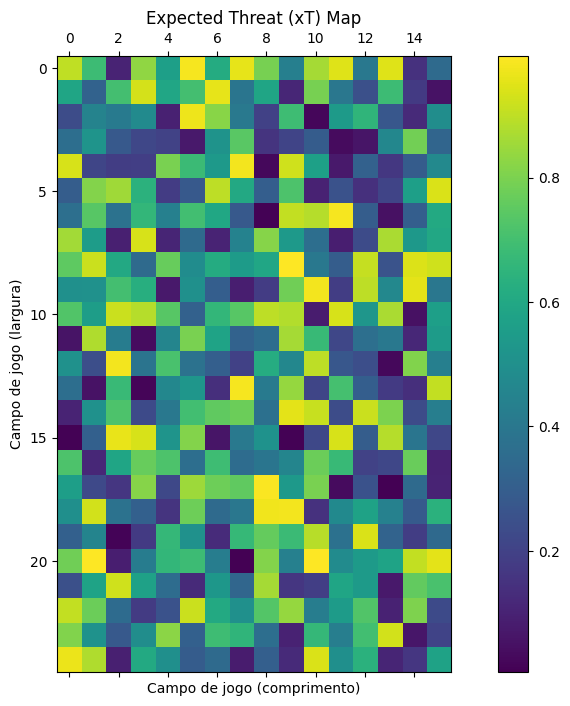

In [ ]:
from socceraction.xthreat import ExpectedThreat
import matplotlib.pyplot as plt

# Instanciando o objeto ExpectedThreat com os parâmetros especificados
xt = ExpectedThreat(l=25, w=16, eps=1e-05)

# Verificando os parâmetros do objeto
print(f"ExpectedThreat instantiated with l={xt.l}, w={xt.w}, eps={xt.eps}")

xT_map = np.random.rand(xt.l, xt.w)

fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(xT_map, cmap='viridis')
plt.title('Expected Threat (xT) Map')
plt.xlabel('Campo de jogo (comprimento)')
plt.ylabel('Campo de jogo (largura)')
plt.colorbar(cax)
plt.show()


# iterations:  29


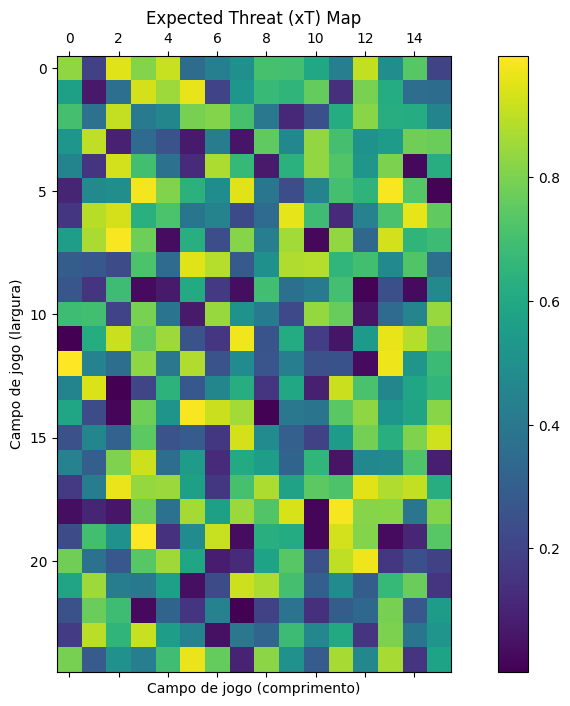

In [ ]:
from socceraction.xthreat import ExpectedThreat

# Instanciar o modelo ExpectedThreat com os parâmetros desejados
xt_model = ExpectedThreat(l=25, w=16, eps=1e-05)

# Ajustar o modelo ExpectedThreat com base nas ações do DataFrame "spadl"
xt_model.fit(spadl)

# Opcional: Verificar o resultado do ajuste do modelo (por exemplo, plotar o mapa de xT)
import matplotlib.pyplot as plt
import numpy as np

# Criação de um mapa xT fictício para ilustração
xT_map = np.random.rand(xt_model.l, xt_model.w)

fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(xT_map, cmap='viridis')
plt.title('Expected Threat (xT) Map')
plt.xlabel('Campo de jogo (comprimento)')
plt.ylabel('Campo de jogo (largura)')
plt.colorbar(cax)
plt.show()

## Questão 5
- Crie um dataframe "prog_actions" à partir do dataframe "spadl", contendo apenas as ações de progressão e que são bem-sucedidas [3].
- Use o método rate do objeto ExpectedThreat p/ calcular o valor de cada ação de progressão do dataframe "prog_actions", em uma coluna chamada "action_value".
- Agrupe o dataframe "prog_actions" por "player_name" e reporte a soma dos "action_value".
- Reporte os 10 jogadores com maior "action_value".

In [ ]:
import pandas as pd

def get_successful_move_actions(actions):
    # Definir critérios para ações de progressão de bola
    progressive_actions = actions[
        (actions['type_name'].isin(['pass', 'dribble', 'cross'])) &  # Tipos de ações
        (actions['result_name'] == 'success') &  # Apenas ações bem-sucedidas
        (
            (actions['type_name'] == 'pass') & ((actions['end_x'] - actions['start_x']) > 10) |  # Passes progressivos
            (actions['type_name'] == 'dribble') & ((actions['end_x'] - actions['start_x']) > 5)   # Dribles progressivos
        )
    ]
    return progressive_actions

prog_actions = get_successful_move_actions(spadl)
prog_actions

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name
0,2565548,1,2.994582,682,3542,38.85,26.52,52.50,34.00,180864419,0,0,1,0,pass,success,foot,Manuel Trigueros Mu\u00f1oz
7,2565548,1,28.831334,682,3486,13.65,31.96,34.65,40.12,180864425,0,0,1,7,pass,success,foot,Andr\u00e9s Eduardo Fern\u00e1ndez Moreno
9,2565548,1,34.267339,682,3695,34.65,14.28,56.70,1.36,180864427,0,0,1,9,pass,success,foot,\u00c1lvaro Gonz\u00e1lez Sober\u00f3n
10,2565548,1,36.051867,682,15214,56.70,1.36,71.40,10.88,180864428,0,0,1,10,pass,success,foot,Antonio Rukavina
11,2565548,1,39.291345,682,22578,71.40,10.88,90.30,9.52,180864430,0,0,1,11,pass,success,foot,Nicola Sansone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474709,2565927,2,2876.959208,682,286994,28.35,63.92,42.00,65.28,253302651,0,0,1,1471,pass,success,foot,Adri\u00e1n Mar\u00edn G\u00f3mez
474713,2565927,2,2928.665268,682,3695,14.70,55.08,37.80,44.88,NaN,0,21,1,1475,dribble,success,foot,\u00c1lvaro Gonz\u00e1lez Sober\u00f3n
474715,2565927,2,2932.188168,682,20623,47.25,32.64,69.30,51.00,253302667,0,21,1,1477,dribble,success,foot,Roberto Soriano
474716,2565927,2,2939.077491,682,20623,69.30,51.00,92.40,66.64,253302671,0,0,1,1478,pass,success,foot,Roberto Soriano


In [ ]:
pip install scipy

In [ ]:
import pandas as pd
from socceraction.xthreat import ExpectedThreat

xthreat_values = xt_model.rate(prog_actions, use_interpolation=False)

# Adicionar a ameaça esperada (xT) ao DataFrame "prog_actions"
prog_actions['action_value'] = xthreat_values
prog_actions

<ipython-input-22-c15ebb2917c3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog_actions['action_value'] = xthreat_values


,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name,action_value
0,2565548,1,2.994582,682,3542,38.85,26.52,52.50,34.00,180864419,0,0,1,0,pass,success,foot,Manuel Trigueros Mu\u00f1oz,0.001595
7,2565548,1,28.831334,682,3486,13.65,31.96,34.65,40.12,180864425,0,0,1,7,pass,success,foot,Andr\u00e9s Eduardo Fern\u00e1ndez Moreno,0.001618
9,2565548,1,34.267339,682,3695,34.65,14.28,56.70,1.36,180864427,0,0,1,9,pass,success,foot,\u00c1lvaro Gonz\u00e1lez Sober\u00f3n,0.001902
10,2565548,1,36.051867,682,15214,56.70,1.36,71.40,10.88,180864428,0,0,1,10,pass,success,foot,Antonio Rukavina,0.007803
11,2565548,1,39.291345,682,22578,71.40,10.88,90.30,9.52,180864430,0,0,1,11,pass,success,foot,Nicola Sansone,0.009245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474709,2565927,2,2876.959208,682,286994,28.35,63.92,42.00,65.28,253302651,0,0,1,1471,pass,success,foot,Adri\u00e1n Mar\u00edn G\u00f3mez,0.003163
474713,2565927,2,2928.665268,682,3695,14.70,55.08,37.80,44.88,NaN,0,21,1,1475,dribble,success,foot,\u00c1lvaro Gonz\u00e1lez Sober\u00f3n,0.003977
474715,2565927,2,2932.188168,682,20623,47.25,32.64,69.30,51.00,253302667,0,21,1,1477,dribble,success,foot,Roberto Soriano,0.005286
474716,2565927,2,2939.077491,682,20623,69.30,51.00,92.40,66.64,253302671,0,0,1,1478,pass,success,foot,Roberto Soriano,0.010294


In [ ]:
import json

def decode_json_unicode(text):
    if isinstance(text, str):
        return json.loads(f'"{text}"')
    return text

prog_actions['player_name'] = prog_actions['player_name'].apply(decode_json_unicode)

player_action_value_sum = prog_actions.groupby('player_name')['action_value'].sum().reset_index()

player_action_value_sum.columns = ['player_name', 'total_action_value']

print(player_action_value_sum)

                       player_name  total_action_value
0             Aarón Martín Caricol            1.594112
1               Achraf Hakimi Mouh            0.690296
2      Adalberto Peñaranda Maestre            0.352518
3                    Adnan Januzaj            1.836205
4         Adrián  González Morales            1.691483
..                             ...                 ...
545  Óscar David Romero Villamayor            0.082834
546       Óscar Esau Duarte Gaitán            0.606414
547          Óscar Melendo Jiménez            0.482282
548          Óscar de Marcos Arana            1.457954
549                  Šime Vrsaljko            0.881781

[550 rows x 2 columns]


<ipython-input-23-f79cf52328af>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog_actions['player_name'] = prog_actions['player_name'].apply(decode_json_unicode)


In [ ]:
player_action_value_sum_sorted = player_action_value_sum.sort_values(by='total_action_value', ascending=False)
top_10_players = player_action_value_sum_sorted.head(10)
print(top_10_players)

                        player_name  total_action_value
326  Lionel Andrés Messi Cuccittini           10.100456
542   Éver Maximiliano David Banega            6.631844
61      Asier Illarramendi Andonegi            5.988405
117             Daniel Parejo Muñoz            5.385135
279            Jonathan Viera Ramos            5.383621
44             Andrés Iniesta Luján            5.176307
240                    Ivan Rakitić            5.070777
341                     Luka Modrić            5.031754
510                      Toni Kroos            4.915227
352  Marcelo Vieira da Silva Júnior            4.810027
